In [1]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import math
from PIL import Image, ImageDraw

import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import gpustat
import pandas as pd
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch import nn
from torchvision.io import read_image
import torchvision.transforms as transforms

import sklearn
import sklearn.model_selection

rng = np.random.default_rng()

In [2]:
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)
print(stats)

GPUStatCollection(host=poppy, [
  [0] NVIDIA A100 80GB PCIe | 64°C,  58 % | 49261 / 81920 MB | akapoor(510M) akapoor(510M) akapoor(510M) akapoor(510M) kkor(47190M)
  [1] NVIDIA A100 80GB PCIe | 31°C, 100 % |  2328 / 81920 MB | natep(2320M)
  [2] NVIDIA A100 80GB PCIe | 33°C, 100 % | 63092 / 81920 MB | murillor(63084M)
])


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Read in dataset to use for training

In [4]:
class KinDataset(Dataset):
    def __init__(self, base_folder, labels_dataframe, spatial_sample = True):
        self.labels = labels_dataframe
        self.base_folder = base_folder
        self.spatial_sample = spatial_sample
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        row = self.labels.iloc[idx,]
        N = row.loc['N'].astype(int)
        n = row.loc['n'].astype(int)
        rep = row.loc['rep'].astype(int)
        group_size = int(row.loc['group_size'])
        if(self.spatial_sample):
            spaghetti_pops_path = f'{self.base_folder}/elephant_data_groupsize{group_size}/pops_{N}_{n}_{rep}.png'
            spaghetti_pops = read_image(spaghetti_pops_path)
            spaghetti_sibs_path = f'{self.base_folder}/elephant_data_groupsize{group_size}/halfsibs_{N}_{n}_{rep}.png'
            spaghetti_sibs = read_image(spaghetti_sibs_path)
            sampling_path = f'{self.base_folder}/elephant_data_groupsize{group_size}/intensity_map_{N}_{n}_{rep}.png'
            intensity_map = read_image(sampling_path)
        else:
            spaghetti_pops_path = f'{self.base_folder}/elephant_data_groupsize{group_size}/random_pops_{N}_{n}_{rep}.png'
            spaghetti_pops = read_image(spaghetti_pops_path)
            spaghetti_sibs_path = f'{self.base_folder}/elephant_data_groupsize{group_size}/random_halfsibs_{N}_{n}_{rep}.png'
            spaghetti_sibs = read_image(spaghetti_sibs_path)
            intensity_map = read_image("allzero.png")
        input_tensor = torch.cat((spaghetti_pops, spaghetti_sibs, intensity_map), 0).float()
        label = torch.tensor([self.labels['N'].iloc[idx]]).float()
        return input_tensor, label, n, group_size

In [5]:
def fix_gs(df):
    nogs_i = np.isnan(df.loc[:,'nfullsibs'])
    df.loc[nogs_i,'nfullsibs'] = df.loc[nogs_i,'nsibs']
    df.loc[nogs_i,'nsibs'] = df.loc[nogs_i,'npops']
    df.loc[nogs_i,'npops'] = df.loc[nogs_i,'group_size']
    df.loc[nogs_i,'group_size'] = 15
    return(df)

In [6]:
spatial_labels = pd.read_csv("/sietch_colab/gpatters/ckmr/elephants/spatial_labels.csv")
spatial_labels = fix_gs(spatial_labels)

### Train on only sample size 300 and population size >=500

In [7]:
labels = spatial_labels.query('n == 291 and N >= 500')
labels

,N,rep,N_final,n,group_size,npops,nsibs,nfullsibs
2050,532,1,524,291,15,64,242,2.0
2051,532,2,528,291,15,65,232,0.0
2052,532,3,536,291,15,67,186,0.0
2053,532,4,521,291,15,76,254,2.0
2054,532,5,527,291,15,60,308,0.0
...,...,...,...,...,...,...,...,...
14345,3178,46,3189,291,15,29,63,0.0
14346,3178,47,3184,291,15,28,60,0.0
14347,3178,48,3212,291,15,26,43,0.0
14348,3178,49,3212,291,15,36,74,0.0


In [8]:
kin_dataset = KinDataset("/sietch_colab/gpatters/ckmr/elephants", labels, spatial_sample = True)

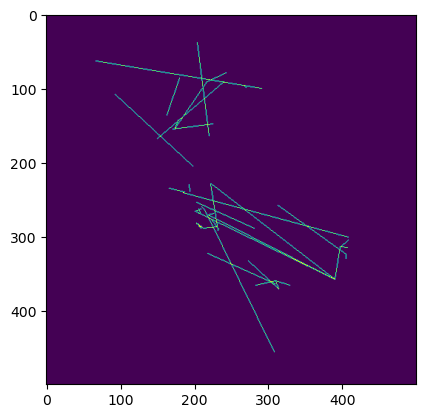

In [19]:
plt.imshow(kin_dataset[2][0][0])
#plt.imshow(kin_dataset[2][0][2])

In [9]:
n_total = len(kin_dataset)
n_train = round(n_total*0.75)
n_valid = round((n_total-n_train)*0.5)
n_test = n_total-n_train-n_valid

In [10]:
train_kin, valid_kin, test_kin = random_split(kin_dataset, [n_train, n_valid, n_test], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_kin_dl = DataLoader(train_kin, batch_size, shuffle = True)
valid_kin_dl = DataLoader(valid_kin, batch_size, shuffle = True)
test_kin_dl = DataLoader(test_kin, batch_size, shuffle = True)
print(len(train_kin))
print(len(valid_kin))
print(len(test_kin))

1875
312
313


In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=6, padding=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6, padding=3)
        self.fc1 = nn.Linear(1000000, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten() 
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = Net()
model = model.to(device) 

In [12]:
loss_fn = nn.MSELoss(reduction='mean')

In [13]:
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch, n, group_size in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)

        loss_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch, n, group_size in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} loss: {loss_hist_train[epoch]:.4f} val_loss: {loss_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid

In [14]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_kin_dl, valid_kin_dl)

Epoch 1 loss: 1192949.8204 val_loss: 517706.3806
Epoch 2 loss: 229611.2692 val_loss: 153681.0014
Epoch 3 loss: 107080.7036 val_loss: 98522.4507
Epoch 4 loss: 76749.6649 val_loss: 82691.2827
Epoch 5 loss: 60506.0032 val_loss: 77746.6735
Epoch 6 loss: 50966.5994 val_loss: 66314.5204
Epoch 7 loss: 43270.8627 val_loss: 65469.6776
Epoch 8 loss: 38923.0540 val_loss: 70938.2770
Epoch 9 loss: 32161.8208 val_loss: 84256.1050
Epoch 10 loss: 37851.6902 val_loss: 62476.6376
Epoch 11 loss: 24093.7348 val_loss: 65807.1530
Epoch 12 loss: 19723.6255 val_loss: 63341.8257
Epoch 13 loss: 17170.0520 val_loss: 61706.4337
Epoch 14 loss: 15858.4377 val_loss: 62368.4470
Epoch 15 loss: 13252.4989 val_loss: 63928.4914
Epoch 16 loss: 12251.6063 val_loss: 62878.5796
Epoch 17 loss: 14087.2170 val_loss: 63380.7107
Epoch 18 loss: 11385.6185 val_loss: 64621.7092
Epoch 19 loss: 10054.3551 val_loss: 74281.6034
Epoch 20 loss: 10677.0764 val_loss: 66242.6359


In [15]:
#Save model
PATH = "model_elephants.pt"
torch.save(model.state_dict(), PATH)

In [30]:
# Save training and test data
labels.to_csv("figures/network_data.csv", index = False)

In [13]:
# Load model
PATH = "model_elephants.pt"
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

/tmp/ipykernel_2063059/2064567138.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH))


Net(
  (conv1): Conv2d(3, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
  (fc1): Linear(in_features=1000000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

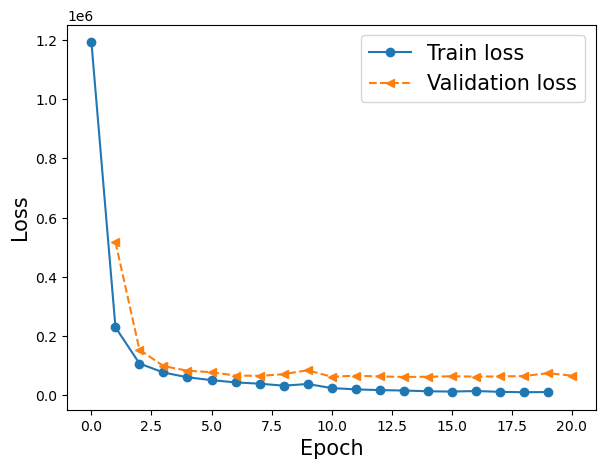

In [17]:
train_x = np.arange(len(hist[0]))
val_x = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_x, hist[0], '-o', label='Train loss')
ax.plot(val_x, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

plt.show()

In [18]:
hist_df = pd.DataFrame({'train_loss': hist[0], 'val_loss': hist[1]})
hist_df.to_csv("figures/network_history.csv", index = True)

In [19]:
test_kin_small, extra_test_kin = random_split(test_kin, [100, n_test-100], generator=torch.Generator().manual_seed(400))

In [20]:
torch.cuda.synchronize()
model_cpu = model.cpu()

test_truth = np.empty(len(test_kin))
test_pred = np.empty(len(test_kin))
test_n = np.empty(len(test_kin))
test_gs = np.empty(len(test_kin))

with torch.no_grad():
    for i, (test_input, test_output, n, group_size) in enumerate(test_kin):
        test_pred[i] = model(test_input.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]
        test_n[i] = n
        test_gs[i] = group_size

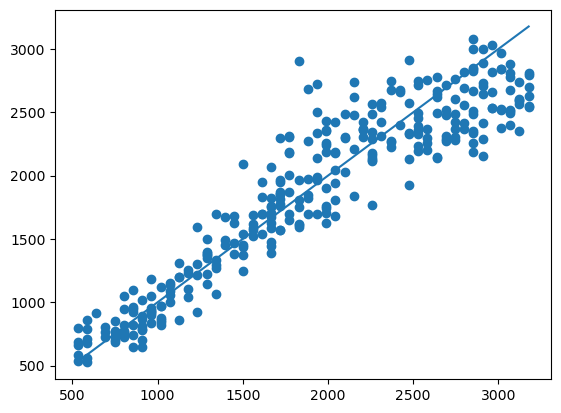

In [21]:
plt.scatter(test_truth, test_pred)
plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])

In [22]:
# Write test results to file
results = {'N': test_truth, 'pred': test_pred, 'n': test_n, 'gs': test_gs}
df = pd.DataFrame(data=results)
df.to_csv("figures/network_results.csv", index = False)

## Is the signal only coming from sampling intensity?

To test, set all kin maps to black in the test data

In [35]:
#test_kin_small, extra_test_kin = random_split(test_kin, [100, n_test-100], generator=torch.Generator().manual_seed(400))

In [23]:
torch.cuda.synchronize()
model_cpu = model.cpu()

test_truth = np.empty(len(test_kin))
test_pred = np.empty(len(test_kin))
test_n = np.empty(len(test_kin))
test_gs = np.empty(len(test_kin))
empty_map = read_image("allzero.png")

with torch.no_grad():
    for i, (test_input, test_output, n, group_size) in enumerate(test_kin):
        spaghetti_pops = empty_map
        spaghetti_sibs = empty_map
        intensity_map = test_input.unsqueeze(1)[2]
        input_tensor = torch.cat((spaghetti_pops, spaghetti_sibs, intensity_map), 0).float()
        test_pred[i] = model(input_tensor.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]
        test_n[i] = n
        test_gs[i] = group_size

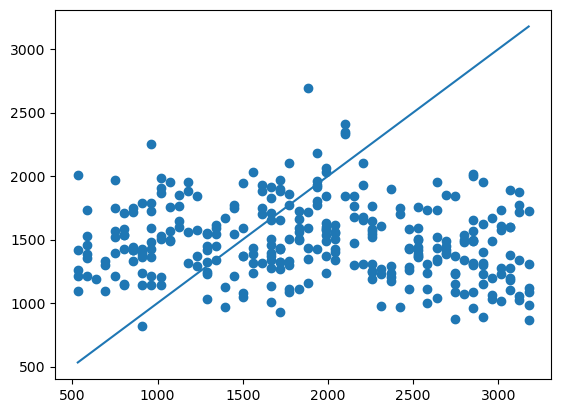

In [24]:
plt.scatter(test_truth, test_pred)
plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])

In [25]:
# Write test results to file
results = {'N': test_truth, 'pred': test_pred, 'n': test_n, 'gs': test_gs}
df = pd.DataFrame(data=results)
df.to_csv("figures/network_results_sampling_only.csv", index = False)

## Is sampling intensity necessary for a signal?

In [70]:
#test_kin_small, extra_test_kin = random_split(test_kin, [100, n_test-100], generator=torch.Generator().manual_seed(400))

In [26]:
torch.cuda.synchronize()
model_cpu = model.cpu()

test_truth = np.empty(len(test_kin))
test_pred = np.empty(len(test_kin))
test_n = np.empty(len(test_kin))
test_gs = np.empty(len(test_kin))
empty_map = read_image("allzero.png")

with torch.no_grad():
    for i, (test_input, test_output, n, group_size) in enumerate(test_kin):
        spaghetti_pops = test_input.unsqueeze(1)[0]
        spaghetti_sibs = test_input.unsqueeze(1)[1]
        intensity_map = empty_map
        input_tensor = torch.cat((spaghetti_pops, spaghetti_sibs, intensity_map), 0).float()
        test_pred[i] = model(input_tensor.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]
        test_n[i] = n
        test_gs[i] = group_size

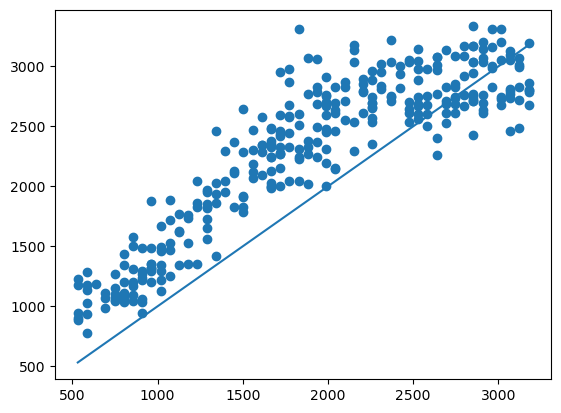

In [27]:
plt.scatter(test_truth, test_pred)
plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])

In [29]:
# Write test results to file
results = {'N': test_truth, 'pred': test_pred, 'n': test_n, 'gs': test_gs}
df = pd.DataFrame(data=results)
df.to_csv("figures/network_results_no_sampling.csv", index = False)

## Use sample size as input to the network

In [29]:
class KinDataset(Dataset):
    def __init__(self, base_folder, labels_dataframe, spatial_sample = True):
        self.labels = labels_dataframe
        self.base_folder = base_folder
        self.spatial_sample = spatial_sample
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        row = self.labels.iloc[idx,]
        N = row.loc['N'].astype(int)
        n = row.loc['n'].astype(int)
        rep = row.loc['rep'].astype(int)
        group_size = int(row.loc['group_size'])
        if(self.spatial_sample):
            spaghetti_pops_path = f'{self.base_folder}/elephant_data_groupsize{group_size}/pops_{N}_{n}_{rep}.png'
            spaghetti_pops = read_image(spaghetti_pops_path)
            spaghetti_sibs_path = f'{self.base_folder}/elephant_data_groupsize{group_size}/halfsibs_{N}_{n}_{rep}.png'
            spaghetti_sibs = read_image(spaghetti_sibs_path)
            sampling_path = f'{self.base_folder}/elephant_data_groupsize{group_size}/intensity_map_{N}_{n}_{rep}.png'
            intensity_map = read_image(sampling_path)
        else:
            spaghetti_pops_path = f'{self.base_folder}/elephant_data_groupsize{group_size}/random_pops_{N}_{n}_{rep}.png'
            spaghetti_pops = read_image(spaghetti_pops_path)
            spaghetti_sibs_path = f'{self.base_folder}/elephant_data_groupsize{group_size}/random_halfsibs_{N}_{n}_{rep}.png'
            spaghetti_sibs = read_image(spaghetti_sibs_path)
            intensity_map = read_image("allzero.png")
        input_tensor = torch.cat((spaghetti_pops, spaghetti_sibs, intensity_map), 0).float()
        label = torch.tensor([self.labels['N'].iloc[idx]]).float()
        return input_tensor, label, torch.tensor([n]), group_size

### Train only on population size >300

In [30]:
labels = spatial_labels.query('N > 300')
labels

,N,rep,N_final,n,group_size,npops,nsibs,nfullsibs
1000,316,1,312,82,15,8,39,2.0
1001,316,2,316,82,15,8,33,0.0
1002,316,3,315,82,15,19,57,0.0
1003,316,4,310,82,15,12,35,0.0
1004,316,5,315,82,15,8,41,0.0
...,...,...,...,...,...,...,...,...
14495,3178,46,3194,1000,15,164,572,0.0
14496,3178,47,3188,1000,15,168,610,0.0
14497,3178,48,3225,1000,15,179,591,0.0
14498,3178,49,3215,1000,15,155,598,2.0


In [31]:
kin_dataset = KinDataset("/sietch_colab/gpatters/ckmr/elephants", labels, spatial_sample = True)

In [32]:
spaghetti_pops_path = "figures/pops_586_1000_11.png"
spaghetti_pops = read_image(spaghetti_pops_path)
spaghetti_sibs_path = "figures/halfsibs_586_1000_11.png"
spaghetti_sibs = read_image(spaghetti_sibs_path)
sampling_path = "intensity_map.png"
intensity_map = read_image(sampling_path)
input_tensor = torch.cat((spaghetti_pops, spaghetti_sibs, intensity_map), 0).float()

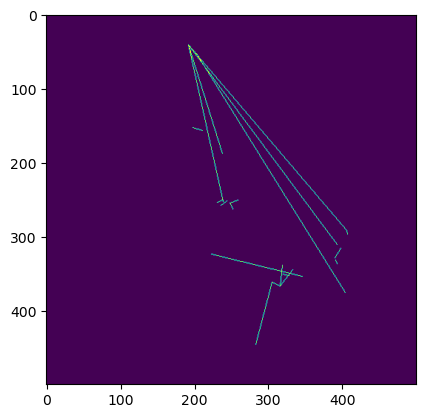

In [33]:
plt.imshow(kin_dataset[2][0][0])
#plt.imshow(kin_dataset[2][0][2])

In [34]:
n_total = len(kin_dataset)
n_train = round(n_total*0.75)
n_valid = round((n_total-n_train)*0.5)
n_test = n_total-n_train-n_valid

In [35]:
train_kin, valid_kin, test_kin = random_split(kin_dataset, [n_train, n_valid, n_test], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_kin_dl = DataLoader(train_kin, batch_size, shuffle = True)
valid_kin_dl = DataLoader(valid_kin, batch_size, shuffle = True)
test_kin_dl = DataLoader(test_kin, batch_size, shuffle = True)
print(len(train_kin))
print(len(valid_kin))
print(len(test_kin))

10125
1688
1687


In [39]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=6, padding=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6, padding=3)
        self.fc1 = nn.Linear(1000000, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.fc3 = nn.Linear(11, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten() 
    def forward(self, x, n):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = torch.cat([x, n], 0)
        print(x)
        x = self.fc3(x)
        return x

model = Net()
model = model.to(device) 

In [43]:
model(input_tensor.to(device), torch.tensor([1]).to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x15625 and 1000000x1024)

In [81]:
loss_fn = nn.MSELoss(reduction='mean')

In [41]:
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch, n, group_size in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device)
            n = n.to(device)
            pred = model(x_batch, n)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)

        loss_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch, n, group_size in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                n = n.to(device)
                pred = model(x_batch, n)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} loss: {loss_hist_train[epoch]:.4f} val_loss: {loss_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid

In [42]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_kin_dl, valid_kin_dl)

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 10 but got size 1 for tensor number 1 in the list.

In [ ]:
#Save model
PATH = "model_elephants.pt"
torch.save(model.state_dict(), PATH)

In [ ]:
# Save training and test data
labels.to_csv("network_data.csv", index = False)

In [ ]:
# Load model
PATH = "model_elephants.pt"
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

/tmp/ipykernel_2063059/2064567138.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH))


Net(
  (conv1): Conv2d(3, 32, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1), padding=(3, 3))
  (fc1): Linear(in_features=1000000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

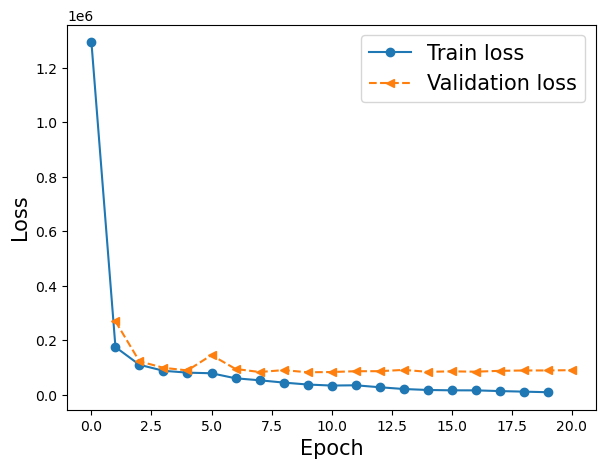

In [ ]:
train_x = np.arange(len(hist[0]))
val_x = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_x, hist[0], '-o', label='Train loss')
ax.plot(val_x, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

plt.show()

In [ ]:
hist_df = pd.DataFrame({'train_loss': hist[0], 'val_loss': hist[1]})
hist_df.to_csv("network_history.csv", index = True)

In [ ]:
test_kin_small, extra_test_kin = random_split(test_kin, [100, n_test-100], generator=torch.Generator().manual_seed(400))

In [ ]:
torch.cuda.synchronize()
model_cpu = model.cpu()

test_truth = np.empty(len(test_kin))
test_pred = np.empty(len(test_kin))
test_n = np.empty(len(test_kin))
test_gs = np.empty(len(test_kin))

with torch.no_grad():
    for i, (test_input, test_output, n, group_size) in enumerate(test_kin):
        test_pred[i] = model(test_input.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]
        test_n[i] = n
        test_gs[i] = group_size

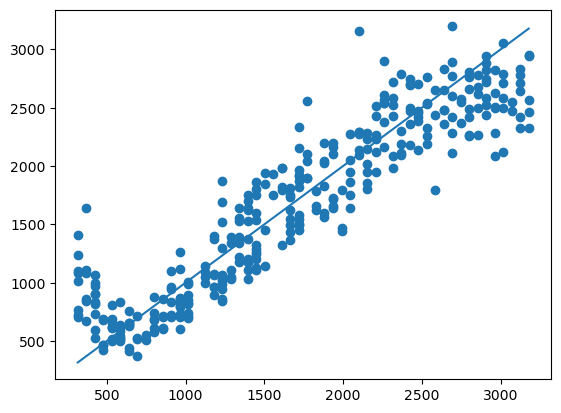

In [ ]:
plt.scatter(test_truth, test_pred)
plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])

In [ ]:
# Write test results to file
results = {'N': test_truth, 'pred': test_pred, 'n': test_n, 'gs': test_gs}
df = pd.DataFrame(data=results)
df.to_csv("network_results.csv", index = False)